In [1]:

#J_Learn_ML_PyTorch_mnist_02_mlp
# Fit MLP on mnist
import numpy as np

import torch
import torchvision

import os
import matplotlib.pyplot as plt
%matplotlib inline
import copy

from IPython.core.debugger import Pdb


## 1. Loading data, and sampling mechanisms

In [2]:
# 1.1 Dataset
trainset=torchvision.datasets.MNIST('/tmp',train=True,download=True,
                                    transform=torchvision.transforms.ToTensor())

# 1.3 train-validation partition
tvRatio=0.8
batchSz=128

nSample=len(trainset)
nTrain=int(nSample*tvRatio)
idxPerm=np.random.permutation(nSample)
idx_t=idxPerm[:nTrain]
idx_v=idxPerm[nTrain:]

sampler_t=torch.utils.data.sampler.SubsetRandomSampler(idx_t)
sampler_v=torch.utils.data.sampler.SubsetRandomSampler(idx_v)

loader_t=torch.utils.data.DataLoader(dataset=trainset,batch_size=batchSz,sampler=sampler_t,
                                     drop_last=True)
loader_v=torch.utils.data.DataLoader(dataset=trainset,batch_size=batchSz,sampler=sampler_v,
                                     drop_last=False)


0.1%

100.1%

Extracting /tmp/MNIST/raw/train-images-idx3-ubyte.gz


1.5%5%

Extracting /tmp/MNIST/raw/train-labels-idx1-ubyte.gz


180.4%

Extracting /tmp/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting /tmp/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


## 2. Specification of neural network

In [3]:
class MLP(torch.nn.Module):
    def __init__(self,nFeat,nClass):
        super(MLP,self).__init__()
        self.fc_1=torch.nn.Linear(nFeat,300)
        self.relu_1=torch.nn.ReLU()
        self.fc_o=torch.nn.Linear(300,nClass)
        self.out=torch.nn.LogSoftmax(dim=1)
        
    def forward(self,x):
        """x should be [N x nFeature]"""
        x=self.fc_1(x)
        x=self.relu_1(x)
        x=self.fc_o(x)
        x=self.out(x)
        return x

    
# GPU
device=torch.device('cuda:0' if torch.cuda.is_available else 'cpu')
print(device)

cuda:0


## 3. Training
The major steps of training is to
  - Compute the predicated value from the neural network, by calling iutput=net(input)
      - zero out all grad before calling net(), using optimizer.zero_grad()
  - Compute loss, by calling loss=loss_function(output, input)
  - Obtain the derivatives of loss w.r.t. each parameter, by calling loss.backward()
  - Modify the parameters as specified by optimizer, calling optimizer.step()



In [4]:
# Hyperparameters -------
lhyper={'nEpoch':100, 'early':15, 'batchSz':batchSz,
        'lr':0.001, 'lrReduce':0.5, 'lrPatience':6,
        'pDrop':0.0, 'weight_decay':0.5}

# Neural network --------
# Feature dimensions
img,_=next(iter(loader_t))
nFeat=img.size(1)*img.size(2)*img.size(3)
nClass=10 # digits

net=MLP(nFeat,nClass).to(device)
print(net)

# Loss, optimizer -------
#metricF=torch.nn.NLLLoss(reduction='elementwise_mean')  # **look at .grad_fn attribute**
metricF=torch.nn.NLLLoss(reduction='none')  # **look at .grad_fn attribute**
optimizer=torch.optim.Adam(net.parameters(),lr=lhyper['lr'],
                           weight_decay=lhyper['weight_decay'])

# Learning rate scheduler ------
lrScheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',
                                                       factor=lhyper['lrReduce'],
                                                       patience=lhyper['lrPatience'],verbose=True)

MLP(
  (fc_1): Linear(in_features=784, out_features=300, bias=True)
  (relu_1): ReLU()
  (fc_o): Linear(in_features=300, out_features=10, bias=True)
  (out): LogSoftmax()
)


In [5]:
net.train(mode=True)
for iBatch, (img, label) in enumerate(loader_t):
    break


In [6]:
img.shape

torch.Size([128, 1, 28, 28])

In [7]:
optimizer.zero_grad() # Understand why *****
curYp=net(img.view(-1,nFeat).to(device)) # No need of .to(device) here, as net is on cuda
#loss=metricF(curYp,label.to(device)) # with 'elementwise_mean'
loss=torch.sum(metricF(curYp,label.to(device))) # with reduction='none'

In [8]:
curYp.shape

torch.Size([128, 10])

In [9]:
label.shape

torch.Size([128])

0/100: loss train=0.4283, val=0.2837
  bestEpoch=0, val=0.2837
1/100: loss train=0.2461, val=0.2241
  bestEpoch=1, val=0.2241
2/100: loss train=0.2115, val=0.1960
  bestEpoch=2, val=0.1960
3/100: loss train=0.1951, val=0.1983
  bestEpoch=2, val=0.1960
4/100: loss train=0.1855, val=0.1744
  bestEpoch=4, val=0.1744
5/100: loss train=0.1780, val=0.1738
  bestEpoch=5, val=0.1738
6/100: loss train=0.1730, val=0.1726
  bestEpoch=6, val=0.1726
7/100: loss train=0.1717, val=0.1682
  bestEpoch=7, val=0.1682
8/100: loss train=0.1701, val=0.1638
  bestEpoch=8, val=0.1638
9/100: loss train=0.1683, val=0.1767
  bestEpoch=8, val=0.1638
10/100: loss train=0.1683, val=0.1667
  bestEpoch=8, val=0.1638
11/100: loss train=0.1673, val=0.1700
  bestEpoch=8, val=0.1638
12/100: loss train=0.1646, val=0.1695
  bestEpoch=8, val=0.1638
13/100: loss train=0.1659, val=0.1617
  bestEpoch=13, val=0.1617
14/100: loss train=0.1648, val=0.1693
  bestEpoch=13, val=0.1617
15/100: loss train=0.1641, val=0.1614
  bestEpoc

Text(0.5,0,'epoch')

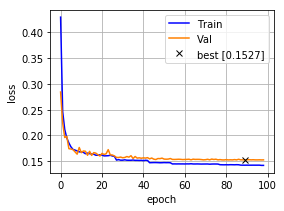

In [13]:
lossC={'t':np.zeros((lhyper['nEpoch'],),dtype=np.float32),
       'v':np.zeros((lhyper['nEpoch'],),dtype=np.float32)}
bestLoss={'t':np.inf, 'v':np.inf, 'epoch':-1}
bestWeight=None

# Training loop ------
for iEpoch in range(lhyper['nEpoch']):
    # Train
    net.train(mode=True)
    for iBatch, (img, label) in enumerate(loader_t):
        optimizer.zero_grad() # Understand why *****
        curYp=net(img.view(-1,nFeat).to(device)) # No need of .to(device) here, as net is on cuda
        #loss=metricF(curYp,label.to(device)) # with 'elementwise_mean'
        loss=torch.sum(metricF(curYp,label.to(device))) # with reduction='none'
        loss.backward()
        optimizer.step()
        lossC['t'][iEpoch]+=loss.item()
    lossC['t'][iEpoch] /= (iBatch+1)*batchSz # Training discarded incomplete batch
    #lossC['t'][iEpoch] /= (iBatch+1) # with 'elementwise_mean'
        
    # Validation
    net.train(mode=False)
    for iBatch, (img, label) in enumerate(loader_v):
        curYp=net(img.view(-1,nFeat).to(device))
        #loss=metricF(curYp,label.to(device)) # with 'elementwise_mean'
        loss=torch.sum(metricF(curYp,label.to(device)))
        lossC['v'][iEpoch]+=loss.item()
    lossC['v'][iEpoch] /= idx_v.shape[0] # Validation uses all data
    #lossC['v'][iEpoch] /= (iBatch+1) # with 'elementwise_mean'
    
    # End of epoch processing: lr adjustment, early stop, loop output
    if lossC['v'][iEpoch]<bestLoss['v']:
        bestLoss.update({'t':lossC['t'][iEpoch], 'v':lossC['v'][iEpoch], 'epoch':iEpoch})
        bestWeight=copy.deepcopy(net.state_dict())
    print('{:d}/{:d}: loss train={:.4f}, val={:.4f}'.format(iEpoch,lhyper['nEpoch'],lossC['t'][iEpoch],
                                                            lossC['v'][iEpoch]))
    print('  bestEpoch={:d}, val={:.4f}'.format(bestLoss['epoch'],bestLoss['v']))
    if iEpoch>bestLoss['epoch']+lhyper['early']:
        break
    lrScheduler.step(lossC['v'][iEpoch])
lastEpoch=iEpoch

# Learning curve -----
plt.figure(1,figsize=(4,3))
plt.clf()
_,ax=plt.subplots(nrows=1,ncols=1,num=1)
ax.plot(lossC['t'][:lastEpoch],'-',color='b',label='Train')
ax.plot(lossC['v'][:lastEpoch],'-',color=[1,.5,0],label='Val')
ax.plot(bestLoss['epoch'],bestLoss['v'],'x',color='k',label='best [{:.4f}]'.format(bestLoss['v']))
ax.legend()
ax.grid()
ax.set_ylabel('loss')
ax.set_xlabel('epoch')

## 4. Evaluation

In [14]:
def predict(model,loader,nFeat):
    """Predict
    
    Need nFeat to convert image (2D) to vector
    """
    pv=[]
    label=[]
    loss=0
    for iBatch, (img, label_) in enumerate(loader):
        label.append(label_.numpy())
        curYp=net(img.view(-1,nFeat).to(model['device']))
        loss+=torch.sum(model['metric'](curYp,label_.to(model['device']))).data.item()
        pv.append(curYp.to('cpu').detach().numpy())
    pv=np.concatenate(pv,axis=0)
    label=np.concatenate(label,axis=0)
    return pv,label,loss

# Best net
bestNet=MLP(nFeat,nClass)
bestNet.load_state_dict(bestWeight)
bestNet.to(device)
bestNet.train(mode=False)

model={'net':bestNet, 'metric':metricF, 'device':device}

In [15]:
# Training
pv_t,label_t,loss_t=predict(model,loader_t,nFeat)
pred_t=np.argmax(pv_t,axis=1)
print('Train accuracy: {:d}/{:d} = {:.4f}'.format(np.sum(pred_t==label_t),label_t.shape[0],
                                                  np.sum(pred_t==label_t)/label_t.shape[0]) )

# Validation
pv_v,label_v,loss_v=predict(model,loader_v,nFeat)
pred_v=np.argmax(pv_v,axis=1)
print('Validation accuracy: {:d}/{:d} = {:.4f}'.format(np.sum(pred_v==label_v),label_v.shape[0],
                                                       np.sum(pred_v==label_v)/label_v.shape[0]) )


Train accuracy: 46476/48000 = 0.9683
Validation accuracy: 11569/12000 = 0.9641


In [17]:
# compare results with http://yann.lecun.com/exdb/mnist/
checkset=torchvision.datasets.MNIST('/tmp',train=False,download=True,
                                    transform=torchvision.transforms.ToTensor())
loader_c=torch.utils.data.DataLoader(checkset,batch_size=batchSz,shuffle=False)
pv_c,label_c,loss_c=predict(model,loader_c,nFeat)
pred_c=np.argmax(pv_c,axis=1)
print('Test accuracy: 1-{:d}/{:d} = {:.4f}'.format(np.sum(pred_c==label_c),label_c.shape[0],
                                                   1-np.sum(pred_c==label_c)/label_c.shape[0]) )

Test accuracy: 9657/10000 = 0.9657


In [11]:
len(checkset)

10000

## 5. Next step

  - Autoencode and autodecoder, compare with PCA for e.g. 2 dimension code
  - Convolution neural network
      - Visualizing the feature extraction and other ways to understand the neural network behavior
      